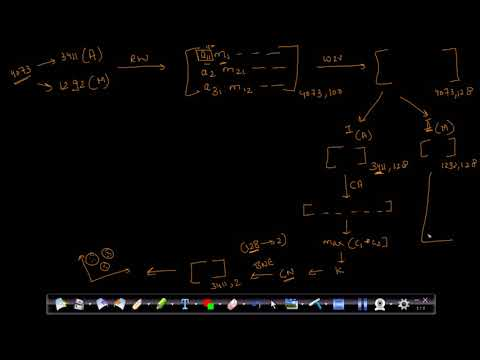

In [4]:
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='Ufe16ie-BPM', width=600)

In [5]:
!pip install stellargraph

In [0]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

1. Read Graph from the given movie_actor_network.csv note that the graph is bipartite graph

In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#logging to avoid discovery_cache error
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

In [0]:
#Get Id of data file and load data in Google Colab

file_list = drive.ListFile({'q': "'1ENR78wQd-pvF1VOhJffeYsTRk8jdmJZx' in parents and trashed=false"}).GetList()
# for file1 in file_list:
  # print('title: %s, id: %s' % (file1['title'], file1['id']))

In [0]:
data_downloaded = drive.CreateFile({'id': '1llSRIVvkE7oeKFNsL1oSrreAqH2dLtB-'})
data_downloaded.GetContentFile('movie_actor_network.csv')

In [0]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

2. Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph

In [0]:
edges = [tuple(x) for x in data.values.tolist()]

In [0]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted by')

In [0]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

A = list(connected_component_subgraphs(B))[0]

In [16]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


In [0]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)

In [0]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

In [0]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5, min_count = 1)

In [20]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [0]:
import numpy
m=[]
a=[]
for i in movies:
  m.append(model[i])
movies_vec=numpy.array(m)
for i in actors:
  a.append(model[i])
actors_vec=numpy.array(a)

3. Apply Clustering Algorithm to group similar actors

	a. For this task consider only the actor nodes <br>
	b. Apply any clustering algorithm of your choice <br>
	c. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
	
    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>
    
	Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
    
	<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

	d. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node<br>
	e. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
	f. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color


In [0]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [0]:
import operator
def cost_1(number,km):
  cost1=0
  for i in range(number):
    EGO_Graph= nx.Graph()
    c=actors_vec[np.array([j for j, x in enumerate(km.labels_) if x == i])]
    
    for j in range(len(c)):
      d=model.similar_by_vector(c[j])
      d=dict(d)
      
      f=max(d.items(), key=operator.itemgetter(1))[0]
      
      P=nx.ego_graph(A,str(f))
      EGO_Graph = nx.compose(P,EGO_Graph)
    nx.connected_components(EGO_Graph)
    Gc = max(connected_component_subgraphs(EGO_Graph), key=len)
    number_of_nodes=Gc.number_of_nodes()
    cost_culus=number_of_nodes/len(c)
    cost1+=cost_culus
    
  costs1=cost1/number
  return costs1

In [0]:
def cost_2(number,km):
  cost2=0
  for i in range(number):
    EGO_Graph= nx.Graph()
    c=actors_vec[np.array([j for j, x in enumerate(km.labels_) if x == i])]

    for j in range(len(c)):
      d=model.similar_by_vector(c[j])
      d=dict(d)
      
      f=max(d.items(), key=operator.itemgetter(1))[0]
      P=nx.ego_graph(A,str(f))
      EGO_Graph = nx.compose(P,EGO_Graph)

    deg=EGO_Graph.degree()
    deg=dict(deg)
    deg_sum=sum(deg.values())
    X = {n for n, d in EGO_Graph.nodes(data=True) if d['bipartite']==0}
    Y = set(EGO_Graph) - X
    cost2_culus= deg_sum/len(Y)
    cost2+=cost2_culus
  costs2=cost2/number
  return costs2

In [25]:
import operator
from sklearn.cluster import KMeans
dict_cost={}
for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
  km = KMeans(n_clusters=number_of_clusters, random_state=0).fit(actors_vec)
  cost1=cost_1(number_of_clusters,km)
  cost2=cost_2(number_of_clusters,km) 
  
  Cost = cost1*cost2

  dict_cost.update({number_of_clusters:Cost}) 
cluster_max_cost=max(dict_cost.items(), key=operator.itemgetter(1))[0]
print(dict_cost)
print("Number of clusters with maximum cost: ",cluster_max_cost)

{3: 227.35112792781973, 5: 498.8674100179103, 10: 172.72288295095674, 30: 441.39049517461507, 50: 710.513826625201, 100: 1379.8101355073413, 200: 942.2723220603982, 500: 262.70544660084806}
Number of clusters with maximum cost:  100


In [0]:
km = KMeans(n_clusters=100, random_state=0).fit(actors_vec)
labels_node=km.labels_

In [0]:
# Retrieve node embeddings and corresponding subjects
node_ids=[]
node_embeddings=[]
for i in range(100):
  c=actors_vec[np.array([j for j, x in enumerate(km.labels_) if x == i])]

  for j in range(len(c)):
    node_embeddings.append(c[j])
    d=model.similar_by_vector(c[j])
    d=dict(d)
      
    f=max(d.items(), key=operator.itemgetter(1))[0]
    node_ids.append(f)
#node_ids = model.wv.index2word  # list of node IDs
node_embeddings=numpy.array(node_embeddings)

#  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.nodes[node_id]['label'] for node_id in node_ids]

In [0]:
from sklearn.manifold import TSNE
transform = TSNE #PCA
#node_embeddings = model.wv.vectors
#print(type(node_embeddings))
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

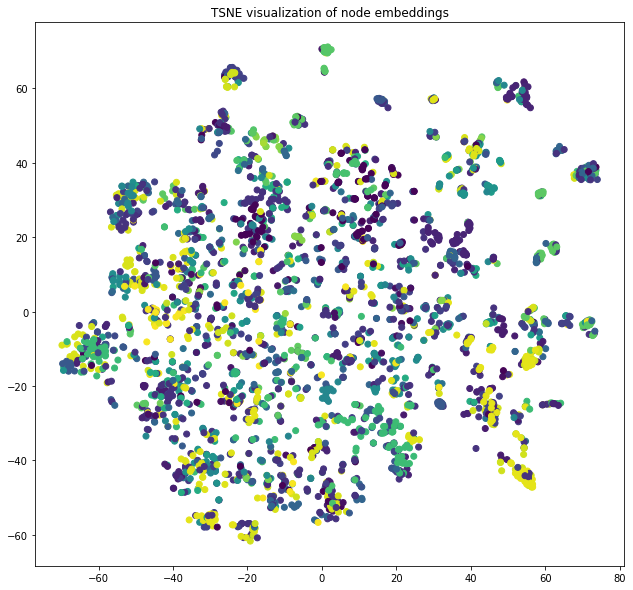

In [29]:
import numpy as np
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(20,10))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=km.labels_.astype(float))
#plt.scatter(data[:,0], data[:,1], c=km.labels_.astype(float))
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()

4. Apply Clustering Algorithm to group similar movies

	a. for this task consider only the movie nodes
  
	b. apply any clustering algorithm of your choice
  
	c. choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
	
	Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ where N= number of clusters 

	<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

	d. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
	e. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
	f. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

In [0]:
import operator
def cost_1(number,km):
  cost1=0
  for i in range(number):
    EGO_Graph= nx.Graph()
    c=movies_vec[np.array([j for j, x in enumerate(km.labels_) if x == i])]

    for j in range(len(c)):
      d=model.similar_by_vector(c[j])
      d=dict(d)
      
      f=max(d.items(), key=operator.itemgetter(1))[0]
      
      P=nx.ego_graph(A,str(f))
      EGO_Graph = nx.compose(P,EGO_Graph)
    nx.connected_components(EGO_Graph)
    Gc = max(connected_component_subgraphs(EGO_Graph), key=len)
    number_of_nodes=Gc.number_of_nodes()
    cost_culus=number_of_nodes/len(c)
    cost1+=cost_culus
    
  costs1=cost1/number
  return costs1

In [0]:
def cost_2(number,km):
  cost2=0
  for i in range(number):
    EGO_Graph= nx.Graph()
    c=movies_vec[np.array([j for j, x in enumerate(km.labels_) if x == i])]

    for j in range(len(c)):
      d=model.similar_by_vector(c[j])
      d=dict(d)
      
      f=max(d.items(), key=operator.itemgetter(1))[0]
      P=nx.ego_graph(A,str(f))
      EGO_Graph = nx.compose(P,EGO_Graph)
    deg=EGO_Graph.degree()
    deg=dict(deg)
    deg_sum=sum(deg.values())
    X = {n for n, d in EGO_Graph.nodes(data=True) if d['bipartite']==0}
    Y = set(EGO_Graph) - X
    cost2_culus= deg_sum/len(Y)
   
    cost2+=cost2_culus
    
  costs2=cost2/number
 
  return costs2

In [32]:
import operator
from sklearn.cluster import KMeans
dict_cost={}
for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
  km = KMeans(n_clusters=number_of_clusters, random_state=0).fit(movies_vec)
  cost1=cost_1(number_of_clusters,km)
  cost2=cost_2(number_of_clusters,km) 
  
  Cost = cost1*cost2
  
  dict_cost.update({number_of_clusters:Cost}) 
cluster_max_cost=max(dict_cost.items(), key=operator.itemgetter(1))[0]
print(dict_cost)
print("Number of clusters with maximum cost: ",cluster_max_cost)

{3: 31.111385515551806, 5: 32.78476684621549, 10: 38.41171603491903, 30: 42.57041066421637, 50: 45.80281563007828, 100: 41.7884685887168, 200: 35.251846887915335, 500: 26.11186736966781}
Number of clusters with maximum cost:  50


In [0]:
km = KMeans(n_clusters=50, random_state=0).fit(movies_vec)
labels_node=km.labels_

In [0]:
# Retrieve node embeddings and corresponding subjects
node_ids=[]
node_embeddings=[]
for i in range(50):
  c=movies_vec[np.array([j for j, x in enumerate(km.labels_) if x == i])]
  
  for j in range(len(c)):
    node_embeddings.append(c[j])
    d=model.similar_by_vector(c[j])
    d=dict(d)
      
    f=max(d.items(), key=operator.itemgetter(1))[0]
    node_ids.append(f)
#node_ids = model.wv.index2word  # list of node IDs
node_embeddings=numpy.array(node_embeddings)

#  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.nodes[node_id]['label'] for node_id in node_ids]

In [0]:
from sklearn.manifold import TSNE
transform = TSNE #PCA
#node_embeddings = model.wv.vectors
#print(type(node_embeddings))
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

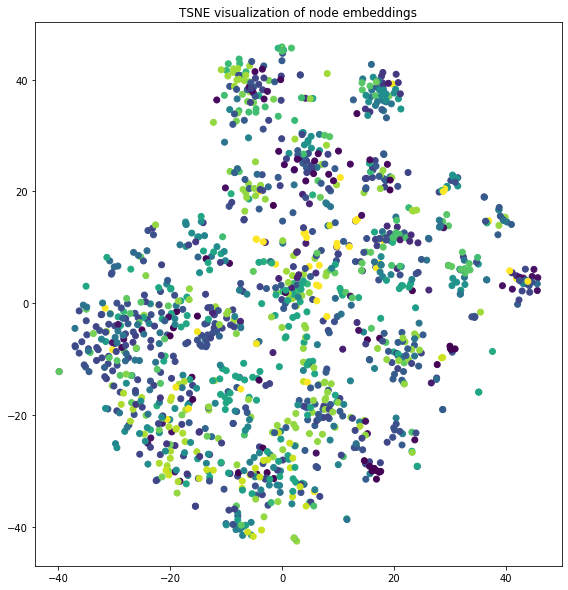

In [36]:
import numpy as np

label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(20,10))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=km.labels_.astype(float))
#plt.scatter(data[:,0], data[:,1], c=km.labels_.astype(float))
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()

<img src='https://i.imgur.com/4SPYPFa.jpg'>

### these links and function might be usefull while solving this assignment
1. what is bipartite graph: https://en.wikipedia.org/wiki/Bipartite_graph
2. Ego graph: https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.ego.ego_graph.html
3. Combining two are more graphs: https://stackoverflow.com/a/32652764/4084039
    ex: if you want to merge three graphs which are mentiond in the above image, you can write like this
    <pre>
    U=nx.Graph()
    for i in number of clusters:
        if U is empty:
            U.add_edges_from(ith Cluster's graph.edges(data=True))
            U.add_nodes_from(ith Cluster's graph.nodes(data=True)) 
        else:
            U.add_edges_from(ith Cluster's graph.edges(data=True)+U.edges(data=True))
            U.add_nodes_from(ith Cluster's graph.nodes(data=True)+U.nodes(data=True))
    </pre>
4. connected components:  https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html
5. Degree of a node: https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.Graph.degree.html
6. Neighbors of node: https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.Graph.neighbors.html

References:-
 1. https://stackoverflow.com/
 2. https://github.com/
 3. https://towardsdatascience.com/ 
 4. https://scikit-learn.org/
 5. https://pythonspot.com/
 6. https://machinelearningmastery.com/
 7. https://stackexchange.com/